# Permeability prediction

findfont: Font family ['Helvetica'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Helvetica'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Helvetica'] not found. Falling back to DejaVu Sans.


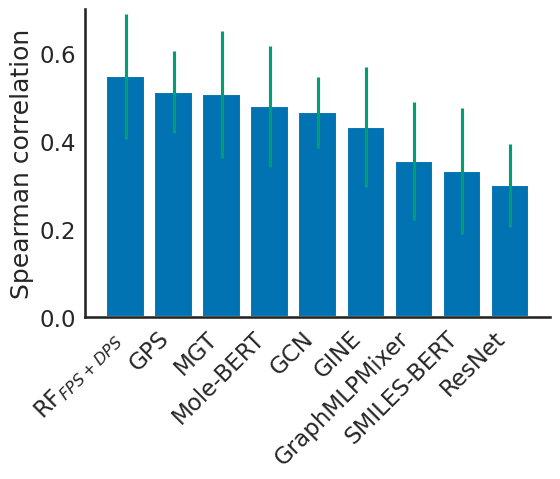

In [1]:
import numpy as np
from utils import plot_style_utils

methods = ['RF$_{FPS+DPS}$','GPS','MGT','Mole-BERT','GCN','GINE','GraphMLPMixer','SMILES-BERT', 'ResNet']
spearman = [0.547, 0.512, 0.506, 0.479, 0.465, 0.432, 0.355, 0.332, 0.299]
spearman_std = [0.142, 0.093, 0.144, 0.137, 0.081, 0.136, 0.134, 0.144, 0.095]

plot_style_utils.set_pub_plot_context(context="talk")
fig, ax = plot_style_utils.simple_ax()
plot_style_utils.prettify_ax(ax)

ax.bar(methods, spearman, color=plot_style_utils.CAT_PALETTE[0])
ax.errorbar(methods, spearman, yerr=spearman_std, fmt='none', ecolor=plot_style_utils.CAT_PALETTE[2])
ax.set_ylabel('Spearman correlation')
ax.set_ylim([0,0.7])
ax.set_xticks(methods)
ax.set_xticklabels(methods, rotation=45, ha='right')
plot_style_utils.save_for_pub(fig=fig, path='figures/cpp/cpp_pred_model_cmp')

## Plot scatter plot

In [2]:
import pandas as pd
data_df = pd.read_csv('data/cpp/all.csv.gz')

x range: -10.0 -3.9
y range: 0.00025642639012531744 0.07258625985969343


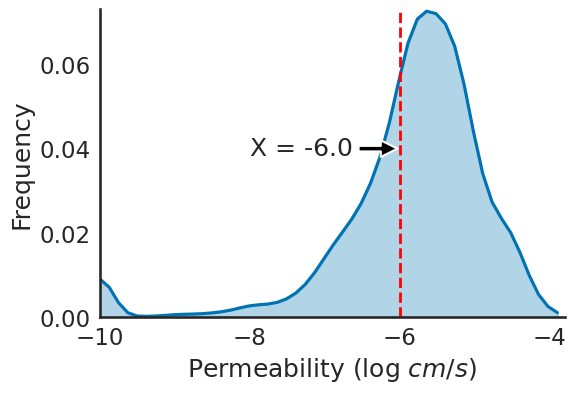

In [3]:
import matplotlib.pyplot as plt
from utils import plot_style_utils
import scipy.stats as stats
import numpy as np

fig, ax = plot_style_utils.simple_ax()
plot_style_utils.set_pub_plot_context(context="talk")
plot_style_utils.prettify_ax(ax)

# plot density of scores
scores = data_df['score'].values
x_min = np.min(scores)
x_max = np.max(scores)

x = np.linspace(x_min, x_max, 50)
y = stats.gaussian_kde(scores)(x)/sum(stats.gaussian_kde(scores)(x))

print('x range:', x_min, x_max)
print('y range:', np.min(y), np.max(y))

# ax.hist(df_data['score'], bins=100, color=plot_style_utils.CAT_PALETTE[0])
ax.plot(x, y, color=plot_style_utils.CAT_PALETTE[0])
ax.fill_between(x, 0, y, alpha=0.3, color=plot_style_utils.CAT_PALETTE[0])
ax.set_xlim(-10, -3.8)
ax.set_ylim(0, 0.073)

# draw vertical lines from x=-6.0
ax.vlines(x=-6.0, ymin=0, ymax=0.32, color='red', linestyle='--', linewidth=2)
ax.annotate('X = -6.0', xy=(-6.0, 0.04), xytext=(-8.0, 0.04), verticalalignment="center",
            arrowprops=dict(facecolor='black', shrink=0.05))

ax.set_xlabel('Permeability (log $cm/s$)')
ax.set_ylabel('Frequency')

plot_style_utils.save_for_pub(fig=fig, path='figures/cpp/cpp_permeability_dist')

In [4]:
import os.path as osp

features = ['fps','dps']
X_features = []
for feat in features:
    feat_path = osp.join('data/cpp', f'X_{feat}.npy')
    try:
        X_feat = np.load(feat_path)
        X_features.append(X_feat)
    except:
        raise ValueError(f'Feature {feat} not found in dir {feat_path}!')
X = np.concatenate(X_features, axis=1)
y = data_df['score'].values

In [5]:
import pickle

val_split = 7
split_file = 'data/cpp/scaffold_k_fold_idxes.pkl'
with open(split_file, 'rb') as f:
    split_idx = pickle.load(f)

val_idx = split_idx[val_split]
test_idx = split_idx[val_split+1]
train_splits = [split_idx[i] for i in range(len(split_idx))if i != val_split+1 and i != val_split]  # the rest are training data
train_idx = np.concatenate(train_splits, axis=0)

In [6]:
X_train, X_val, X_test = X[train_idx], X[val_idx], X[test_idx]
y_train, y_val, y_test = y[train_idx], y[val_idx], y[test_idx]

## Modeling

In [7]:
import joblib

save_path='data/cpp/regression_rf.pkl'

model = joblib.load(save_path)
y_train_hat = model.predict(X_train)
y_val_hat = model.predict(X_val)
y_test_hat = model.predict(X_test)

/home/xiaopeng/Desktop/CPP_design/env/lib/python3.7/site-packages/sklearn/base.py:334: UserWarning: Trying to unpickle estimator DecisionTreeRegressor from version 0.23.2 when using version 0.23.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/home/xiaopeng/Desktop/CPP_design/env/lib/python3.7/site-packages/sklearn/base.py:334: UserWarning: Trying to unpickle estimator RandomForestRegressor from version 0.23.2 when using version 0.23.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


In [8]:
from scipy import stats


spearman = stats.spearmanr(y_train_hat, y_train)
print(f'Train Spearman: {spearman[0]:.3f}, p-value: {spearman[1]:.3f}')
spearman = stats.spearmanr(y_val_hat, y_val)
print(f'Val Spearman: {spearman[0]:.3f}, p-value: {spearman[1]:.3f}')
spearman = stats.spearmanr(y_test_hat, y_test)
print(f'Test Spearman: {spearman[0]:.3f}, p-value: {spearman[1]:.3f}')

y_hat_val_test = np.concatenate([y_val_hat, y_test_hat])
y_val_test = np.concatenate([y_val, y_test])
spearman = stats.spearmanr(y_hat_val_test, y_val_test)
print(f'Val+Test Spearman: {spearman[0]:.3f}, p-value: {spearman[1]:.3f}')

Train Spearman: 0.781, p-value: 0.000
Val Spearman: 0.626, p-value: 0.000
Test Spearman: 0.974, p-value: 0.000
Val+Test Spearman: 0.825, p-value: 0.000


x range: -10.0 -4.0
y range: -9.748300000000002 -4.3423


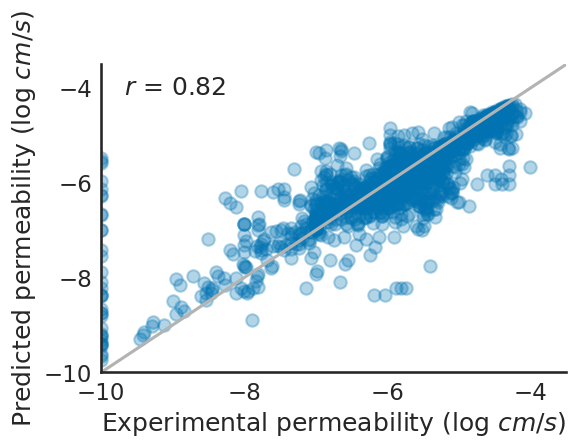

In [9]:
import numpy as np
from utils import plot_style_utils

plot_style_utils.set_pub_plot_context(context="talk")
fig, ax = plot_style_utils.simple_ax()

ax.scatter(y_val, y_val_hat, alpha=0.3, label='Val', color=plot_style_utils.CAT_PALETTE[0])
ax.scatter(y_test, y_test_hat, alpha=0.3, label='Test', color=plot_style_utils.CAT_PALETTE[0])

ax.set_xlabel('Experimental permeability (log $cm/s$)')
ax.set_ylabel('Predicted permeability (log $cm/s$)')

print('x range:', min(np.min(y_val), np.min(y_test)), max(np.max(y_val), np.max(y_test)))
print('y range:', min(np.min(y_val_hat), np.min(y_test_hat)), max(np.max(y_val_hat), np.max(y_test_hat)))
minv = -10
maxv = -3.5
ax.set_xlim([minv, maxv])
ax.set_ylim([minv, maxv])
ax.plot([minv, maxv], [minv, maxv], '-', color=[0.7, 0.7, 0.7])
ax.text(0.05, 0.9, '$\it{r}$ = %0.2f'%spearman[0], transform=ax.transAxes)

plot_style_utils.prettify_ax(ax)
plot_style_utils.save_for_pub(fig=fig, path='figures/cpp/cpp_pred_scatter')


## Feature importance

In [10]:
X_features[0].shape, X_features[1].shape

((7451, 2048), (7451, 211))

In [11]:
from rdkit.Chem import Descriptors, rdMolDescriptors

descriptor_names = [x[0] for x in Descriptors._descList] + ['CalcNumLipinskiHBD', 'CalcNumLipinskiHBA', 'CalcNumRotatableBonds']

features = [f'fps{i+1}' for i in range(2048)] + descriptor_names
importance = model.feature_importances_
indices = np.argsort(importance)[::-1]

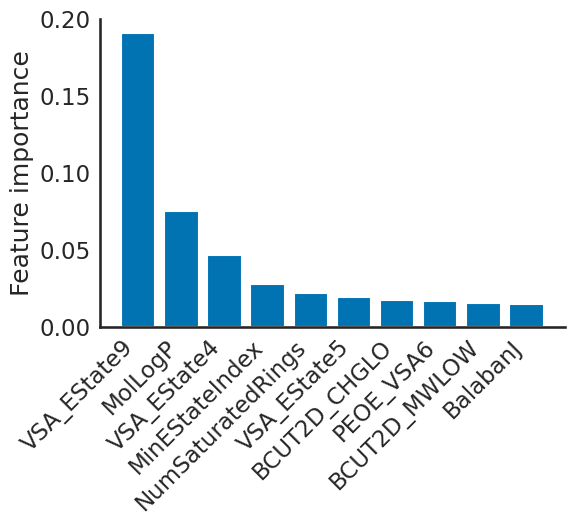

In [12]:
# Plot bar plot
plot_style_utils.set_pub_plot_context(context="talk")
fig, ax = plot_style_utils.simple_ax()
plot_style_utils.prettify_ax(ax)

top_10_features = [features[indices[i]] for i in range(10)]
top_10_feature_importance = [importance[indices[i]] for i in range(10)]
ax.bar(top_10_features, top_10_feature_importance, color=plot_style_utils.CAT_PALETTE[0])
ax.set_ylabel('Feature importance')
ax.set_xticks(top_10_features)
ax.set_xticklabels(top_10_features, rotation=45, ha='right')
ax.set_ylim([0,0.20])
plot_style_utils.save_for_pub(fig=fig, path='figures/cpp/cpp_pred_feature_importance')